In [11]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd 
import numpy as np
import xgboost
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import matplotlib.pyplot as plt
from datetime import datetime

In [13]:
df_data = pd.read_excel("./研討會財務比率(完整版3).xlsx")

In [3]:
df_data

,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,負債比率,股票代號,45天後日期,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率
0,0,1101,台泥,2013/03,1,11A,1.22,1.06,-4.65,1.28,46.72,1101.tw,2013-05-15,31.917610,17.8100,1.3050,1.1650,0.800,41.170
1,1,1101,台泥,2013/06,2,11A,2.03,2.69,-1.84,1.34,49.12,1101.tw,2013-08-15,31.310814,8.1600,1.9850,2.4800,0.820,43.790
2,2,1101,台泥,2013/09,3,11A,2.63,3.78,2.13,1.48,46.62,1101.tw,2013-11-15,34.344807,22.3750,1.6500,1.7400,0.960,41.160
3,3,1101,台泥,2013/12,4,11A,2.24,2.66,11.72,1.51,45.66,1101.tw,2013-2-15,31.513079,15.5450,2.4350,2.7250,0.950,35.580
4,4,1101,台泥,2014/03,1,11A,1.56,1.70,10.79,1.48,44.62,1101.tw,2014-05-15,36.650642,23.3950,1.6300,1.5900,0.920,36.910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32474,32474,912398,友佳-DR,2019/06,2,15A1,1.80,2.91,-12.59,0.05,67.68,912398.tw,2019-08-15,NaN,24.6600,1.8000,3.8900,1.280,57.350
32475,32475,912398,友佳-DR,2019/12,4,15A1,0.09,-1.38,-27.04,0.05,66.65,912398.tw,2019-2-15,NaN,-8.1475,0.3350,-0.0725,1.295,57.045
32476,32476,912398,友佳-DR,2020/06,2,15A1,-3.56,-14.16,-28.68,0.05,71.91,912398.tw,2020-08-15,NaN,-9.3075,1.2050,1.2700,1.070,55.730
32477,32477,912398,友佳-DR,2020/12,4,15A1,-7.23,-27.49,31.89,0.16,77.06,912398.tw,2020-2-15,NaN,35.5225,1.4700,1.4725,1.165,58.495


In [4]:
df_data["代號"] = df_data["代號"].astype("str")
df_data["年/月"] = df_data["年/月"].astype("str")
df_data["TEJ子產業代碼"] = df_data["TEJ子產業代碼"].astype("str")

In [5]:
#計算下季報酬率(Y)
def seasonRor(df):
  #新增年月欄
  df['年月'] = [ x[:4]+x[5:7] for x in df['年/月'] ]
  #Y
  df['下季報酬'] = df.groupby('代號').apply(lambda x : x['45天後股價'].shift(-1)/x['45天後股價']-1 ).reset_index(level=0,drop=True)
  # 去除缺值
  df = df.dropna(subset=['下季報酬'])
  return df

In [6]:
seasonRor(df = df_data)

,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,...,股票代號,45天後日期,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率,年月,下季報酬
0,0,1101,台泥,2013/03,1,11A,1.22,1.06,-4.65,1.28,...,1101.tw,2013-05-15,31.917610,17.8100,1.3050,1.1650,0.800,41.170,201303,-0.019011
1,1,1101,台泥,2013/06,2,11A,2.03,2.69,-1.84,1.34,...,1101.tw,2013-08-15,31.310814,8.1600,1.9850,2.4800,0.820,43.790,201306,0.096899
2,2,1101,台泥,2013/09,3,11A,2.63,3.78,2.13,1.48,...,1101.tw,2013-11-15,34.344807,22.3750,1.6500,1.7400,0.960,41.160,201309,-0.082450
3,3,1101,台泥,2013/12,4,11A,2.24,2.66,11.72,1.51,...,1101.tw,2013-2-15,31.513079,15.5450,2.4350,2.7250,0.950,35.580,201312,0.163030
4,4,1101,台泥,2014/03,1,11A,1.56,1.70,10.79,1.48,...,1101.tw,2014-05-15,36.650642,23.3950,1.6300,1.5900,0.920,36.910,201403,0.014349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,32456,912000,晨訊科-DR,2018/12,4,230,-0.62,-4.51,-54.13,0.01,...,912000.tw,2018-2-15,2.820000,24.7425,1.5700,2.0175,1.275,44.185,201812,-0.301418
32457,32457,912000,晨訊科-DR,2019/06,2,230,-0.55,-4.22,-65.33,0.01,...,912000.tw,2019-08-15,1.970000,21.8200,1.8150,2.2875,1.305,47.360,201906,0.482234
32458,32458,912000,晨訊科-DR,2019/12,4,230,2.50,0.82,-8.24,0.01,...,912000.tw,2019-2-15,2.920000,-1.7875,1.7750,1.9775,1.400,43.965,201912,0.308219
32459,32459,912000,晨訊科-DR,2020/06,2,230,0.48,-2.06,-19.75,0.01,...,912000.tw,2020-08-15,3.820000,-4.8175,1.5425,2.3525,1.470,51.585,202006,-0.455497


In [7]:
df_data.dropna(inplace=True)
df_data.reset_index(drop=True,inplace=True)

In [8]:
df_data

,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,...,股票代號,45天後日期,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率,年月,下季報酬
0,0,1101,台泥,2013/03,1,11A,1.22,1.06,-4.65,1.28,...,1101.tw,2013-05-15,31.917610,17.8100,1.3050,1.1650,0.800,41.170,201303,-0.019011
1,1,1101,台泥,2013/06,2,11A,2.03,2.69,-1.84,1.34,...,1101.tw,2013-08-15,31.310814,8.1600,1.9850,2.4800,0.820,43.790,201306,0.096899
2,2,1101,台泥,2013/09,3,11A,2.63,3.78,2.13,1.48,...,1101.tw,2013-11-15,34.344807,22.3750,1.6500,1.7400,0.960,41.160,201309,-0.082450
3,3,1101,台泥,2013/12,4,11A,2.24,2.66,11.72,1.51,...,1101.tw,2013-2-15,31.513079,15.5450,2.4350,2.7250,0.950,35.580,201312,0.163030
4,4,1101,台泥,2014/03,1,11A,1.56,1.70,10.79,1.48,...,1101.tw,2014-05-15,36.650642,23.3950,1.6300,1.5900,0.920,36.910,201403,0.014349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30511,32456,912000,晨訊科-DR,2018/12,4,230,-0.62,-4.51,-54.13,0.01,...,912000.tw,2018-2-15,2.820000,24.7425,1.5700,2.0175,1.275,44.185,201812,-0.301418
30512,32457,912000,晨訊科-DR,2019/06,2,230,-0.55,-4.22,-65.33,0.01,...,912000.tw,2019-08-15,1.970000,21.8200,1.8150,2.2875,1.305,47.360,201906,0.482234
30513,32458,912000,晨訊科-DR,2019/12,4,230,2.50,0.82,-8.24,0.01,...,912000.tw,2019-2-15,2.920000,-1.7875,1.7750,1.9775,1.400,43.965,201912,0.308219
30514,32459,912000,晨訊科-DR,2020/06,2,230,0.48,-2.06,-19.75,0.01,...,912000.tw,2020-08-15,3.820000,-4.8175,1.5425,2.3525,1.470,51.585,202006,-0.455497


In [9]:
def select(df):
  #篩選符合特徵股票
  #挑選特徵比率大於第三百分位的股票
  condition = (df["ROA(B)稅後息前折舊前"]>=df["子產業Q3ROA(B)稅後息前折舊前"])&(df["ROA(B)稅後息前折舊前"]>0)&(df["ROE(B)－常續利益"]>=df["子產業Q3ROE(B)－常續利益"])&(df["ROE(B)－常續利益"]>0)&(df["營收成長率"]>=df["子產業Q3營收成長率"])&(df["營收成長率"]>0)&(df["當季季底P/B"]<=df["子產業Q2當季季底P/B"])&(df["負債比率"]<=df["子產業Q2負債比率"])
  return df[condition]

In [10]:
df_data_select = select(df_data)
df_data_select

,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,...,股票代號,45天後日期,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率,年月,下季報酬
99,101,1103,嘉泥,2020/12,4,11A,3.61,5.26,10.73,0.61,...,1103.tw,2020-2-15,20.100000,9.6950,2.7100,3.9475,1.040,40.220,202012,-0.017413
145,149,1108,幸福,2015/06,2,11A,3.19,3.78,5.44,0.92,...,1108.tw,2015-08-15,10.150000,-3.4925,2.1350,2.5950,0.950,44.030,201506,-0.009852
173,178,1109,信大,2013/12,4,11A,2.76,2.79,57.27,0.82,...,1109.tw,2013-2-15,12.280701,15.5450,2.4350,2.7250,0.950,35.580,201312,0.371429
187,192,1109,信大,2017/06,2,11A,2.96,2.83,19.22,0.72,...,1109.tw,2017-08-15,11.263157,5.7925,1.8650,2.1700,0.920,35.385,201706,0.149533
188,193,1109,信大,2017/09,3,11A,2.58,2.32,39.88,0.83,...,1109.tw,2017-11-15,12.947368,30.0775,1.6775,1.8550,0.885,34.655,201709,-0.150406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30339,32268,9955,佳龍,2019/03,1,99L1,0.58,0.15,5.75,0.77,...,9955.tw,2019-05-15,12.350000,5.7500,0.5800,0.1500,0.770,43.890,201903,0.700405
30345,32274,9955,佳龍,2020/09,3,99L1,1.17,1.29,121.93,1.19,...,9955.tw,2020-11-15,18.600000,121.9300,1.1700,1.2900,1.190,45.140,202009,-0.032258
30489,32427,911622,泰聚亨-DR,2021/03,1,20A1,4.99,6.26,42.63,0.04,...,911622.tw,2021-05-15,6.570000,38.8000,3.5000,4.7200,1.060,38.510,202103,0.004566
30499,32443,911868,同方友友-DR,2020/12,4,23C6C,5.16,5.24,31.72,0.03,...,911868.tw,2020-2-15,1.070000,24.5150,2.1875,2.3725,1.155,37.695,202012,0.364486


In [11]:
df_data_select["排名"] = df_data_select.groupby("年月")["下季報酬"].rank(method = "first",ascending=False)
df_data_select.reset_index(drop = True)

<ipython-input-11-f5c840f561f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_select["排名"] = df_data_select.groupby("年月")["下季報酬"].rank(method = "first",ascending=False)


,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,...,45天後日期,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率,年月,下季報酬,排名
0,101,1103,嘉泥,2020/12,4,11A,3.61,5.26,10.73,0.61,...,2020-2-15,20.100000,9.6950,2.7100,3.9475,1.040,40.220,202012,-0.017413,29.0
1,149,1108,幸福,2015/06,2,11A,3.19,3.78,5.44,0.92,...,2015-08-15,10.150000,-3.4925,2.1350,2.5950,0.950,44.030,201506,-0.009852,10.0
2,178,1109,信大,2013/12,4,11A,2.76,2.79,57.27,0.82,...,2013-2-15,12.280701,15.5450,2.4350,2.7250,0.950,35.580,201312,0.371429,6.0
3,192,1109,信大,2017/06,2,11A,2.96,2.83,19.22,0.72,...,2017-08-15,11.263157,5.7925,1.8650,2.1700,0.920,35.385,201706,0.149533,8.0
4,193,1109,信大,2017/09,3,11A,2.58,2.32,39.88,0.83,...,2017-11-15,12.947368,30.0775,1.6775,1.8550,0.885,34.655,201709,-0.150406,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,32268,9955,佳龍,2019/03,1,99L1,0.58,0.15,5.75,0.77,...,2019-05-15,12.350000,5.7500,0.5800,0.1500,0.770,43.890,201903,0.700405,1.0
927,32274,9955,佳龍,2020/09,3,99L1,1.17,1.29,121.93,1.19,...,2020-11-15,18.600000,121.9300,1.1700,1.2900,1.190,45.140,202009,-0.032258,11.0
928,32427,911622,泰聚亨-DR,2021/03,1,20A1,4.99,6.26,42.63,0.04,...,2021-05-15,6.570000,38.8000,3.5000,4.7200,1.060,38.510,202103,0.004566,27.0
929,32443,911868,同方友友-DR,2020/12,4,23C6C,5.16,5.24,31.72,0.03,...,2020-2-15,1.070000,24.5150,2.1875,2.3725,1.155,37.695,202012,0.364486,17.0


In [12]:
def stock_select(df,feature_list,target):
  # 模型訓練及選股
  # 切割訓練資料及測試資料
  df_train = df[df['年月']>='201209']
  df_train = df_train[df_train['年月']<'201809']
  df_test = df[df['年月']>='201809']
  df_test = df_test[df_test['年月']<='202106']
  # 訓練模型
  model = xgboost.XGBRegressor()
  model.fit(df_train[features_list],df_train[target])
  print(f'training error:{sqrt(MSE(df_train[target],model.predict(df_train[features_list])))}')
  # 預測資料
  df_test['預測下期報酬'] = model.predict(df_test[features_list])
  print(f'testing error:{sqrt(MSE(df_test[target],model.predict(df_test[features_list])))}')
  # 排序下期預測報酬的公司
  df_test = df_test.sort_values(['年月','預測下期報酬'],ascending=[1,0])
  # 挑選預測報酬前3大公司為下期投資組合
  df_select = df_test.groupby('年月').apply(lambda x : x.head(3)).reset_index(drop=True)
  plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
  plt.show()
  return df_test,df_select

training error:0.00893235585552118
testing error:0.5137722782903973


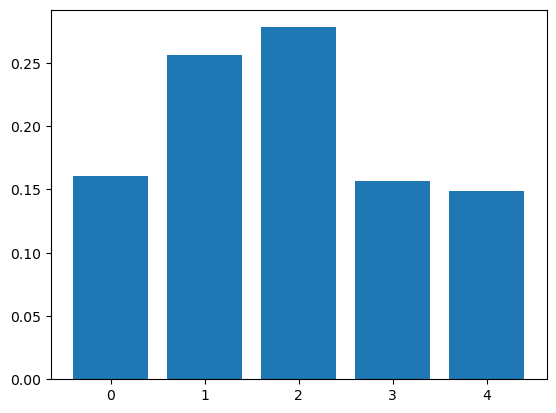

,Unnamed: 0,代號,名稱,年/月,季別,TEJ子產業代碼,ROA(B)稅後息前折舊前,ROE(B)－常續利益,營收成長率,當季季底P/B,...,45天後股價,子產業Q3營收成長率,子產業Q3ROA(B)稅後息前折舊前,子產業Q3ROE(B)－常續利益,子產業Q2當季季底P/B,子產業Q2負債比率,年月,下季報酬,排名,預測下期報酬
0,1943,1414,東和,2018/09,3,14B1,0.83,0.68,74.55,0.56,...,7.010000,29.7225,0.4250,0.0875,0.670,45.390,201809,0.069900,14.0,0.207909
1,1282,1313,聯成,2018/09,3,13A7,1.56,1.37,6.91,0.95,...,10.924790,6.9100,1.5600,1.3700,0.950,56.790,201809,0.506173,1.0,0.169950
2,11368,2408,南亞科,2018/09,3,23G1B,8.60,8.38,83.36,1.13,...,55.900002,46.1850,6.6950,7.6000,1.130,34.020,201809,0.429338,4.0,0.132251
3,28498,6558,興能高,2018/12,4,23D7,3.33,4.30,36.11,2.95,...,37.400002,36.1100,3.3300,4.3000,2.950,27.920,201812,0.596257,4.0,0.170285
4,23807,4927,泰鼎-KY,2018/12,4,23B2D,3.45,4.68,17.63,0.98,...,19.200001,7.0600,2.9400,3.1300,0.980,55.500,201812,1.687500,1.0,0.156909
5,198,1109,信大,2018/12,4,11A,5.76,6.48,21.54,0.76,...,14.789473,19.3300,2.1075,2.7800,0.795,38.320,201812,0.220463,8.0,0.138206
6,25098,5519,隆大,2019/03,1,25A,1.32,2.78,91.30,0.81,...,16.799999,33.8500,1.0400,2.0950,0.900,53.580,201903,0.014881,8.0,0.311994
7,199,1109,信大,2019/03,1,11A,2.85,2.73,28.18,0.76,...,18.049999,11.4000,1.5750,1.8825,0.850,39.680,201903,-0.099723,21.0,0.238037
8,8325,2107,厚生,2019/03,1,21B2,0.68,0.64,59.02,0.57,...,17.250000,59.0200,0.6800,0.6400,0.570,25.260,201903,0.057971,6.0,0.223209
9,18489,3031,佰鴻,2019/06,2,23C6C,2.75,2.46,3.76,0.80,...,12.550000,3.7600,2.2500,2.1600,0.800,34.360,201906,0.235060,5.0,0.183984


In [13]:
# X : 可自行抽換
features_list = ["負債比率","ROA(B)稅後息前折舊前","ROE(B)－常續利益","當季季底P/B","營收成長率"
          ]
# Y : 無須更動
target = ['下季報酬']
df_test,df_select = stock_select(df=df_data_select,feature_list=features_list,target=target)
df_test
df_select.head(35)

In [14]:
df_select[["名稱","年/月","下季報酬","排名","預測下期報酬"]]

,名稱,年/月,下季報酬,排名,預測下期報酬
0,東和,2018/09,0.069900,14.0,0.207909
1,聯成,2018/09,0.506173,1.0,0.169950
2,南亞科,2018/09,0.429338,4.0,0.132251
3,興能高,2018/12,0.596257,4.0,0.170285
4,泰鼎-KY,2018/12,1.687500,1.0,0.156909
5,信大,2018/12,0.220463,8.0,0.138206
6,隆大,2019/03,0.014881,8.0,0.311994
7,信大,2019/03,-0.099723,21.0,0.238037
8,厚生,2019/03,0.057971,6.0,0.223209
9,佰鴻,2019/06,0.235060,5.0,0.183984


In [15]:
def portfolio_return(df):
  # 計算報酬 必須有年月、下季報酬欄位
  return df.groupby('年月')['下季報酬'].mean().reset_index()

In [16]:
df_portfolio_return = portfolio_return(df_select)
df_portfolio_return

,年月,下季報酬
0,201809,0.335137
1,201812,0.834740
2,201903,-0.008957
3,201906,0.320545
4,201909,-0.168081
5,201912,0.356997
6,202003,0.108018
7,202006,0.293906
8,202009,-0.125896
9,202012,0.467363


In [17]:
#加權指數
df_index = pd.read_excel('加權指數.xlsx')
df_index['年月'] = [ x.strftime('%Y%m%d')[:6] for x in  df_index['日期']]
df_index = df_index.drop_duplicates(subset=['年月'])
date_list = ["201809","201812","201903","201906","201909","201912","202003","202006","202009","202012","202103","202106","202109"]
df_index = df_index[df_index['年月'].isin(date_list)].reset_index(drop=True)
df_index['加權報酬指數下季報酬'] = df_index['加權報酬指數'].shift(-1)/df_index['加權報酬指數'] -1
df_index['加權報酬指數下季報酬'].mean()/df_index['加權報酬指數下季報酬'].std()
df_index

,日期,Benchmark,加權報酬指數,彭博巴克萊20年期以上美國公債指數,年月,加權報酬指數下季報酬
0,2018-09-03,152.762846,19539.04,662.8000,201809,-0.074322
1,2018-12-03,143.531200,18086.85,637.8100,201812,0.020913
2,2019-03-04,147.743061,18465.10,664.9900,201903,0.014612
3,2019-06-03,155.547712,18734.92,739.2800,201906,0.054025
4,2019-09-02,168.016850,19747.08,825.7200,201909,0.084369
5,2019-12-02,172.231547,21413.13,781.4600,201912,-0.027121
6,2020-03-02,178.441751,20832.38,884.7200,202003,-0.005425
7,2020-06-01,181.634608,20719.37,927.5100,202006,0.178788
8,2020-09-01,200.709902,24423.75,940.0900,202009,0.095898
9,2020-12-01,208.824620,26765.95,902.9100,202012,0.150185


In [18]:
# 投資組合最大虧損
df_portfolio_return["下季報酬"].min()

-0.16808082435849328

In [19]:
# 投資組合年化報酬率
# 平均年化報酬率 =(((1+平均季報酬率)**4)-1)*100
((1+df_portfolio_return['下季報酬'].mean())**4-1)

1.2658926911344146

In [20]:
#大盤最大虧損
df_index['加權報酬指數下季報酬'].min()

-0.07432248462565216

In [21]:
# 大盤年化報酬率
((1+df_index['加權報酬指數下季報酬'].mean())**4-1)

0.2191616415022284

In [22]:
# 夏普值計算公式
# 夏普指數 = (平均年化報酬率-無風險利率)/年化標準差
# 平均年化報酬率 =(((1+平均季報酬率)**4)-1)*100
# 年化標準差 = (季報酬標準差)*(4)**0.5
((1+df_portfolio_return['下季報酬'].mean())**4-1)/(df_portfolio_return['下季報酬'].std()*4**0.5)

2.1964218846264503

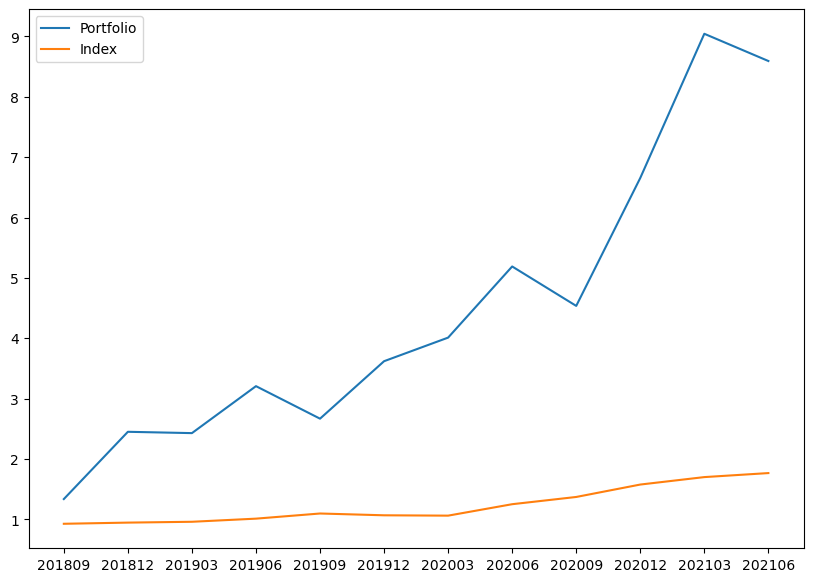

In [23]:
# 累化累積報酬圖
plt.figure(figsize=(10,7))
plt.plot(df_portfolio_return['年月'],(df_portfolio_return['下季報酬']+1).cumprod())
plt.plot(df_index['年月'],(df_index['加權報酬指數下季報酬']+1).cumprod())
plt.legend(["Portfolio","Index"])
plt.rc('legend', fontsize="x-large")
plt.show()